# 1 Introduction
This python notebook for Amazon food reviews polarity prediction based on the given review data by applying K Nearest Neighbors (KNN) algorithm. To build generalized prediction model first step should be necessary cleaning of data as a part of data preprocessing. 

We will perform following data preprocessing. 

* Removing Stop-words
* Remove any punctuations or limited set of special characters like , or . or # etc.
* Snowball Stemming the word 
* Convert the word to lowercase
 
Once we the data is cleaned to be processed we'll use below Feature generation techniques to convert text to numeric vector.
1. Bag Of Words (BoW)
1. Term Frequency - inverse document frequency (tf-idf)
1. Word2Vec
1. tf-idf weighted Word2Vec

Using KNN algorithm we will build model to predict review polarity for each technique. 

**Objective: Given a review determine whether a review is positive or negative, by appling KNN algorithm and deciding the best Feature generation technique for given problem.**




**1.1 Load and check data**

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score


In [2]:
import sqlite3
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite')

filtered_data = pd.read_sql_query("""select * from Reviews WHERE Score != 3""",con)

filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2 Data Preprocessing

*  **Segregating data as positive and negative**

In [3]:
# Here are replacing review score 1,2 as negative and 4,5 as a positive. we are skipping review score 3 considering it as a neutral.
def partition(x):
    if x<3:
        return 'negative'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

* **Sorting data for time based splitting for model train and test dataset**

In [4]:
import datetime

filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

sortedData = filtered_data.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
finalp = final[final.Score == 'positive']
finalp = finalp.sample(frac=0.035,random_state=1) #0.055

finaln = final[final.Score == 'negative']
finaln = finaln.sample(frac=0.15,random_state=1) #0.25

final = pd.concat([finalp,finaln],axis=0)

#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)


print(final.shape)

(19313, 10)


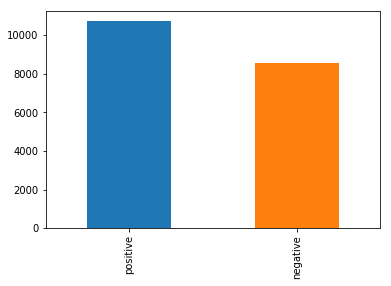

In [5]:
final['Score'].value_counts().plot(kind='bar')

* ** Removing Stop-words **
* ** Remove any punctuations or limited set of special characters like , or . or # etc. **
* ** Snowball Stemming the word ** 
* ** Convert the word to lowercase **

In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

# 3 Building function to find optimal K for KNN

**To Find the optimal K we will used 10 fold cross validation method. Based on misclassifiction error for every K, we will decide the best K on  Train Data**

In [7]:
from sklearn.cross_validation import cross_val_score

def find_optimal_k(X_train,y_train, myList):
   
    #creating odd list of K for KNN
    #myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)


    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k

C:\Users\Jinal\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 4 Feature generation techniques to convert text to numeric vector.[](http://) 

# 4.1 Appling KNN with BoW

**Generating Bag of Wrods Vector matrix for Reviews**

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

#count_vect = CountVectorizer(ngram_range=(1,2) ) 
count_vect = CountVectorizer() 
final_bow_count = count_vect.fit_transform(final_string)#final['Text'].values)

In [24]:
from sklearn.preprocessing import StandardScaler

final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count )


C:\Users\Jinal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


**Splitting Data into Train and Test based on the timestamp of review**

In [25]:
#We already have sorted data by timestamp so we will use first 70% of data as Train with cross validation and next 30% for test
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

X = final_bow_np
y = final['Score']

X_train =  final_bow_np[:math.ceil(len(final)*.7)] 
X_test = final_bow_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

**Finding Optimal K by 10 fold Cross validation**


The optimal number of neighbors is 5.
the misclassification error for each k value is :  [0.377 0.345 0.342 0.352 0.361 0.367 0.377 0.385 0.393 0.399 0.407 0.414
 0.418 0.418 0.421 0.422 0.423 0.424 0.425 0.427 0.428 0.428 0.429 0.429
 0.429]


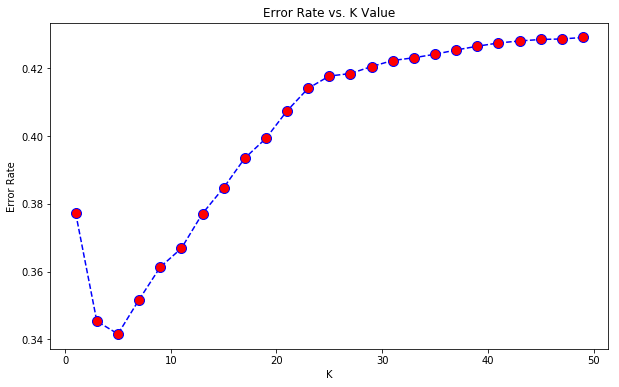

In [11]:
myList = list(range(0,50))

optimal_k = find_optimal_k(X_train ,y_train,myList)



**KNN with Optimal K**

In [12]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [28]:
knnkd = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree')
knnkd.fit(X_train, y_train)
predkd = knnkd.predict(X_test)

C:\Users\Jinal\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


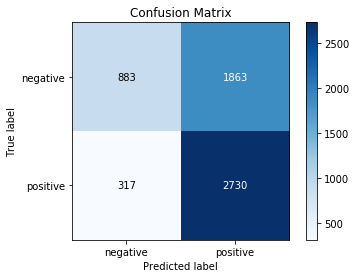

In [13]:
skplt.plot_confusion_matrix(y_test ,pred)

In [14]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.74      0.32      0.45      2746
   positive       0.59      0.90      0.71      3047

avg / total       0.66      0.62      0.59      5793



In [15]:
print("Accuracy for KNN model with Bag of Words is ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with Bag of Words is  0.624


# 4.2 Appling KNN with tf-idf

**Generating tf-idf Vector matrix for Reviews**

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer()#ngram_range=(2,2))

final_tfidf_count = tf_idf_vec.fit_transform(final_string)#final['Text'].values)

#print(final_string)

In [30]:
from sklearn.preprocessing import StandardScaler

final_tfidf_np = StandardScaler(with_mean=False).fit_transform(final_tfidf_count )


**Splitting Data into Train and Test**

In [31]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

X = final_tfidf_np
y = final['Score']

X_train =  final_tfidf_np[:math.ceil(len(final)*.7)] 
X_test = final_tfidf_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]


The optimal number of neighbors is 3.
the misclassification error for each k value is :  [0.411 0.407 0.411 0.42  0.424 0.427 0.429 0.43  0.43  0.43  0.43  0.43
 0.43  0.43  0.43  0.43  0.43  0.43  0.43  0.43 ]


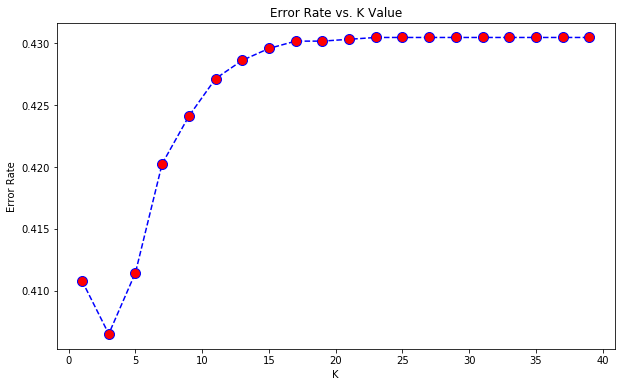

In [19]:
myList = list(range(0,40))

optimal_k = find_optimal_k(X_train ,y_train,myList)


**KNN with Optimal K**

In [20]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [32]:
knnkd = KNeighborsClassifier(n_neighbors=3, algorithm="kd_tree")
knnkd.fit(X_train, y_train)
predkd = knn.predict(X_test)

C:\Users\Jinal\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


ValueError: kd_tree does not work with sparse matrices. Densify the data, or set algorithm='brute'

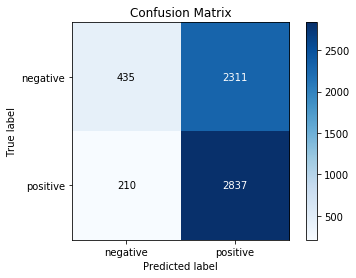

In [21]:
skplt.plot_confusion_matrix(y_test ,predkd)

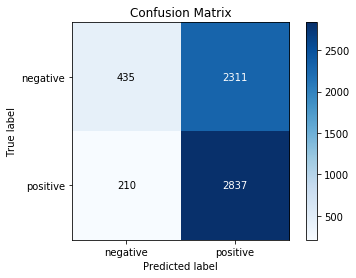

In [21]:
skplt.plot_confusion_matrix(y_test ,pred)

In [22]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.67      0.16      0.26      2746
   positive       0.55      0.93      0.69      3047

avg / total       0.61      0.56      0.49      5793



In [23]:
print("Accuracy for KNN model with tf-id is ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with tf-id is  0.565


# 4.3 Appling KNN with Avg W2V

**Generating W2V Vector matrix for Reviews**

In [8]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


C:\Users\Jinal\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
import gensim
i=0
str1=''
list_of_sent=[]
final_string_for_tfidf = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
    #str1 = b" ".join(filtered_sentence) #final string of cleaned words
            
    #final_string_for_tfidf.append(str1)
    list_of_sent.append(filtered_sentence)
    final_string_for_tfidf.append((str1).strip())

In [10]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)  

In [11]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    

In [ ]:
# from sklearn.preprocessing import StandardScaler

# final_w2v_count = StandardScaler().fit_transform(sent_vectors )

**Splitting Data into Train and Test**

In [29]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

X = final_w2v_count
y = final['Score']

X_train =  final_w2v_count[:math.ceil(len(final)*.7)] 
X_test = final_w2v_count[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

**Finding Optimal K by 10 fold Cross validation**


The optimal number of neighbors is 45.
the misclassification error for each k value is :  [0.22  0.217 0.218 0.216 0.217 0.215]


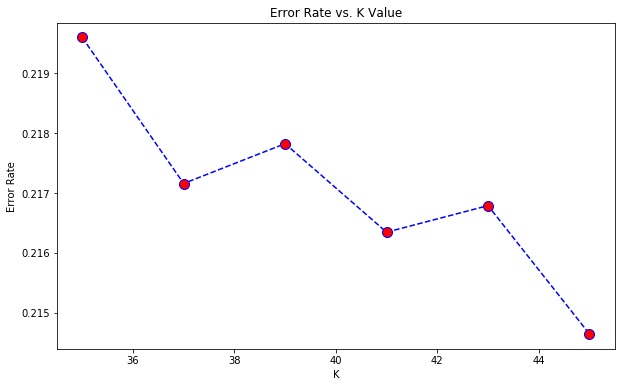

In [30]:
myList = list(range(35,47))

optimal_k = find_optimal_k(X_train ,y_train,myList)


**KNN with Optimal K**

In [31]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

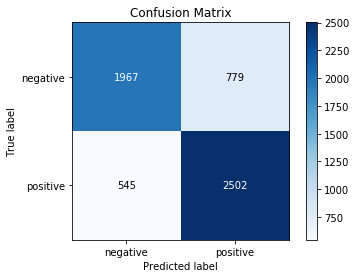

In [32]:
skplt.plot_confusion_matrix(y_test ,pred)

In [33]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.78      0.72      0.75      2746
   positive       0.76      0.82      0.79      3047

avg / total       0.77      0.77      0.77      5793



In [34]:
print("Accuracy for KNN model with Avg Word2Vec is ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with Avg Word2Vec is  0.771


# 4.4 Appling KNN with f-idf weighted Word2Vec

**Generating tf-idf W2V Vector matrix for Reviews**

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec_w = TfidfVectorizer()#ngram_range=(2,2))

final_tfidf_w = tf_idf_vec_w.fit_transform(final_string_for_tfidf)


In [13]:
tfidf_feat = tf_idf_vec_w.get_feature_names()


tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
#             print("vec")
#             print(vec)
            tf_idf = final_tfidf_w[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
#             print("sent_vec")
#             print(sent_vec)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
#     print(sent_vec)
#     print(weight_sum)
    
   # break
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [14]:
# from sklearn.preprocessing import StandardScaler

# final_tfidf_w2v_np = StandardScaler().fit_transform(tfidf_sent_vectors )

**Finding Optimal K by 10 fold Cross validation**

In [17]:
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier


X = tfidf_sent_vectors
y = final['Score']

X_train =  tfidf_sent_vectors[:math.ceil(len(final)*.7)] 
X_test = tfidf_sent_vectors[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

**Finding Optimal K by 10 fold Cross validation**


The optimal number of neighbors is 37.
the misclassification error for each k value is :  [0.322 0.287 0.269 0.263 0.26  0.254 0.254 0.249 0.251 0.248 0.249 0.249
 0.251 0.247 0.249 0.247 0.248 0.247 0.245 0.246]


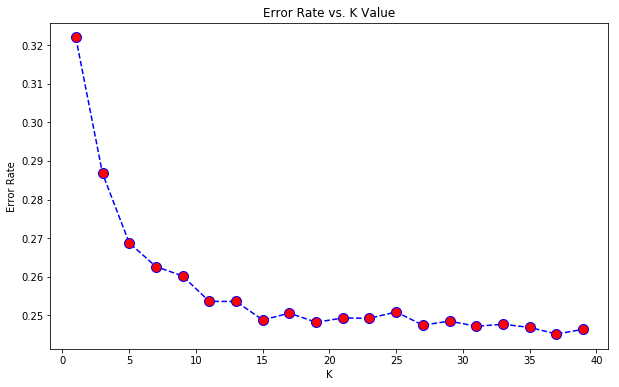

In [18]:
myList = list(range(0,40))

optimal_k = find_optimal_k(X_train ,y_train,myList)


**KNN with Optimal K**

In [19]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

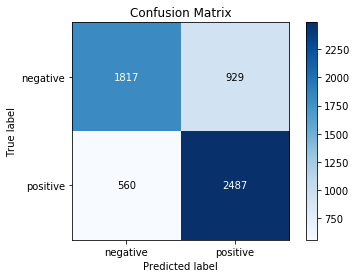

In [20]:
skplt.plot_confusion_matrix(y_test ,pred)

In [21]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.76      0.66      0.71      2746
   positive       0.73      0.82      0.77      3047

avg / total       0.75      0.74      0.74      5793



In [22]:
print("Accuracy for KNN model with tf-idf weighted Word2Vec is ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with tf-idf weighted Word2Vec is  0.743


# 5 Observation
**The result of feature generation techniques and machine learning algorithms vary by application. But by comparing the accuracy of all 4 developed models, KNN model with Avg. w2v feature generation technique gives accuracy more than 75% which is the best to predict the polarity of reviews among all models **
